## Spotify Dataset Exploratory Data Analysis
Aaron Bishop (github@foozbat.net)

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#### Import Spotify dataset and do some initial exploration

In [96]:
df = pd.read_csv("dataset.csv")
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [97]:
print("Dataset shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of duplicate tracks:", df['track_id'].duplicated().sum())
print("Columns with non-numeric values:", df.select_dtypes(exclude=['number']).columns.tolist())

Dataset shape: (114000, 21)
Missing values:
 Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
Number of duplicate rows: 0
Number of duplicate tracks: 24259
Columns with non-numeric values: ['track_id', 'artists', 'album_name', 'track_name', 'explicit', 'track_genre']


In [98]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


#### Initial data pre-processing

In [99]:
# drop null values
df.dropna(inplace=True)

# drop columns with unique identifiers or non-categorical text values
#df2 = df.drop(columns=['track_id', 'track_name', 'album_name','artists'])

# convert non-numeric values to numeric
df['explicit'] = df['explicit'].astype(int)

le = LabelEncoder()

# Encode the 'artists', 'album_name', and 'track_name' columns
df['artists'] = le.fit_transform(df['artists'])
df['album_name'] = le.fit_transform(df['album_name'])
df['track_name'] = le.fit_transform(df['track_name'])
df['track_genre'] = le.fit_transform(df['track_genre'])

# get rid of the redundant ID column since it matches the DF ID
df = df.drop(df.columns[0:2], axis=1)

df.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,10357,8100,11741,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,3287,14796,22528,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,12397,39162,60774,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,14839,8580,9580,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,5255,16899,25689,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


#### Check for outliers

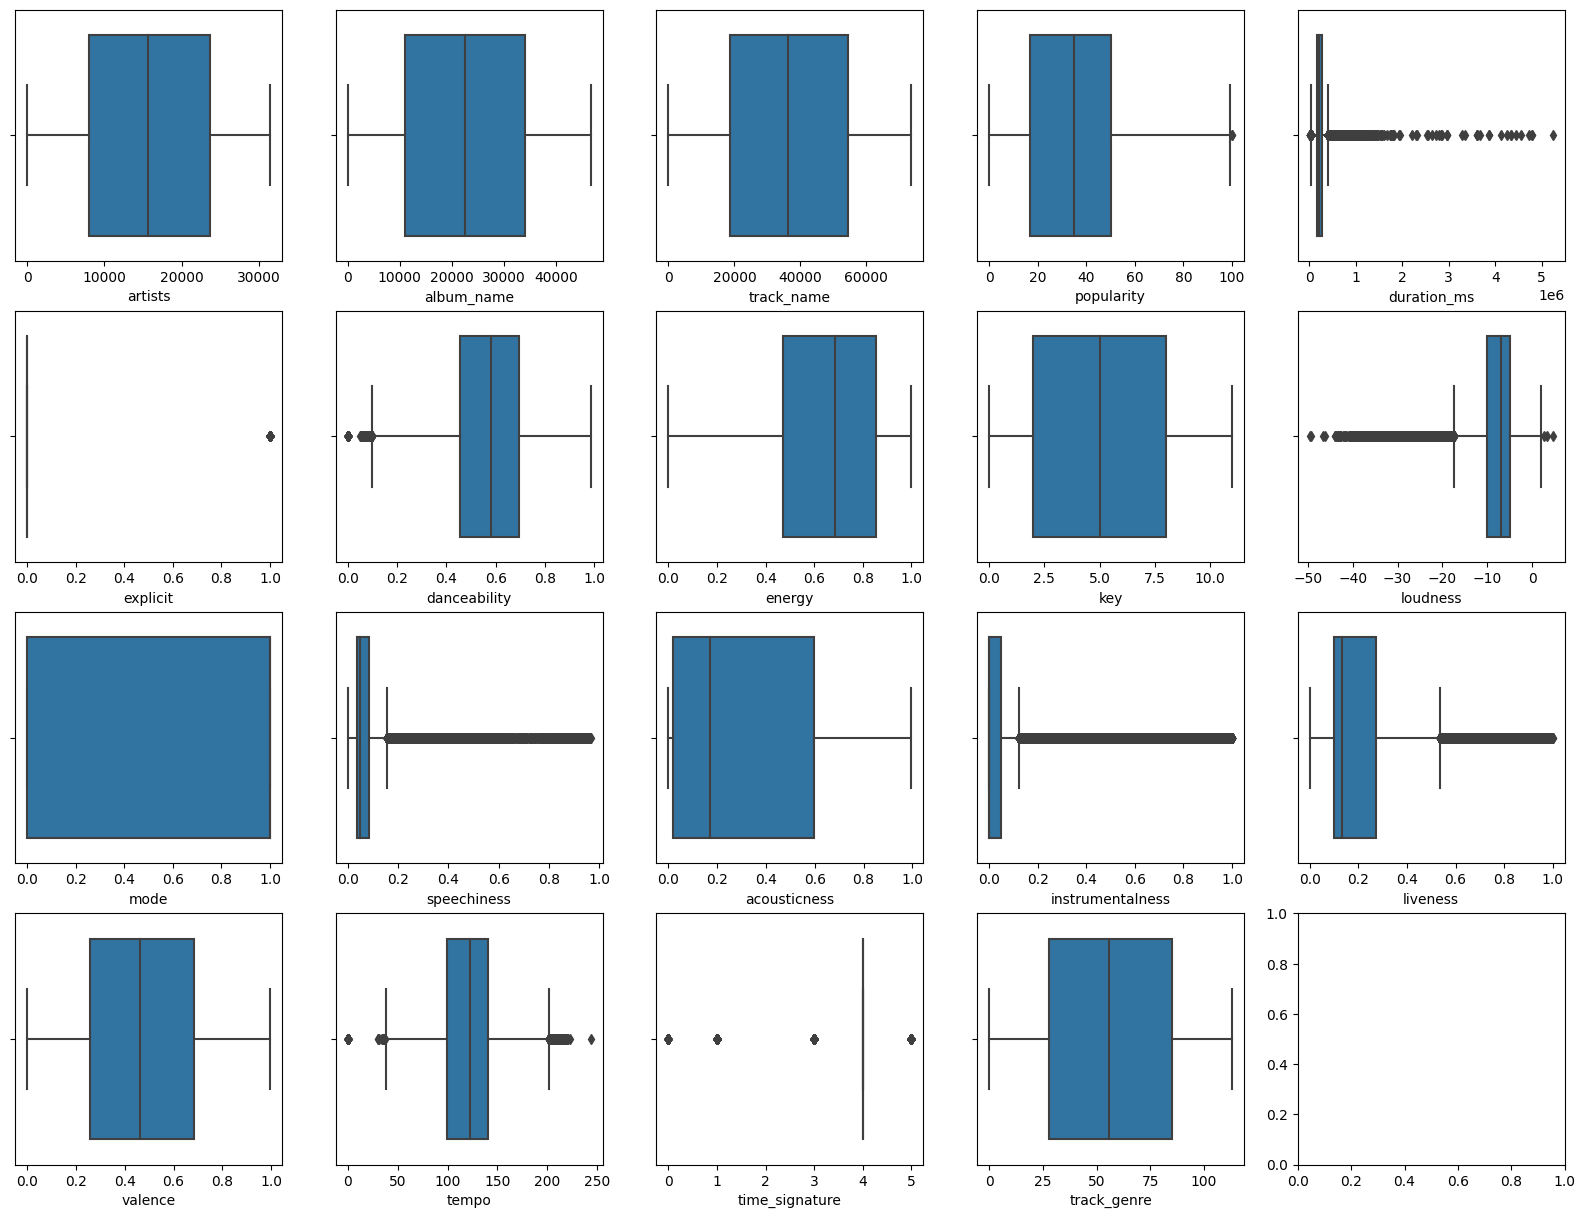

In [100]:
# get the numeric features
features = list(df.columns) #list(df.iloc[:,4:].columns)

fig, axs = plt.subplots(4, 5, figsize=(20, 15))
for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axs[i//5, i%5])
plt.show()

It looks like time_signature, tempo, danceability, and popularity may have some outliers.  Let's investigate.

In [101]:
z_time_sig = np.abs((df['time_signature'] - df['time_signature'].mean()) / df['time_signature'].std())

print("Non-typical time signatures:")
print("0/4 Time: ", len(df[df['time_signature'] == 0]))
print("1/4 Time: ", len(df[df['time_signature'] == 1]))
print("Z-Score Outliers (threshold=3): ", len(df[z_time_sig > 3]))
print()

df[df['time_signature'] == 0].head()

Non-typical time signatures:
0/4 Time:  163
1/4 Time:  973
Z-Score Outliers (threshold=3):  1136



,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
2926,30097,2163,50732,44,213198,0,0.442,0.5670,8,-6.346,0,0.0516,0.238,0.000325,0.0852,0.639,138.616,0,2
4131,18102,41470,58296,64,151506,0,0.000,0.0362,0,-22.519,0,0.0000,0.994,0.940000,0.0958,0.000,0.000,0,4
4379,6727,19059,58396,55,73266,0,0.000,0.0445,0,-26.440,0,0.0000,0.972,0.972000,0.0873,0.000,0.000,0,4
4664,26366,9768,20236,53,68493,0,0.000,0.0323,2,-23.636,0,0.0000,0.994,0.973000,0.0922,0.000,0.000,0,4
26910,3322,16512,25097,18,203705,0,0.329,0.0607,9,-28.310,1,0.0507,0.994,0.880000,0.0858,0.421,93.948,0,26


In [85]:
df[df['popularity'] == 100]

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
20001,24119,40423,62957,100,156943,0,0.714,0.472,2,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,20
81051,24119,40423,62957,100,156943,0,0.714,0.472,2,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,80


Some instrumental, background, and foriegn music may make use of non-traditional time signatures or have no time signature at all.  The data supports this observation, so we won't count these as outliers.  Danceability is subjective and tempo can vary widely, so I don't consider those outliers.  The song with popularity=100 was apparently a chart topper upon researching, so again probably not an outlier.

### Correlation

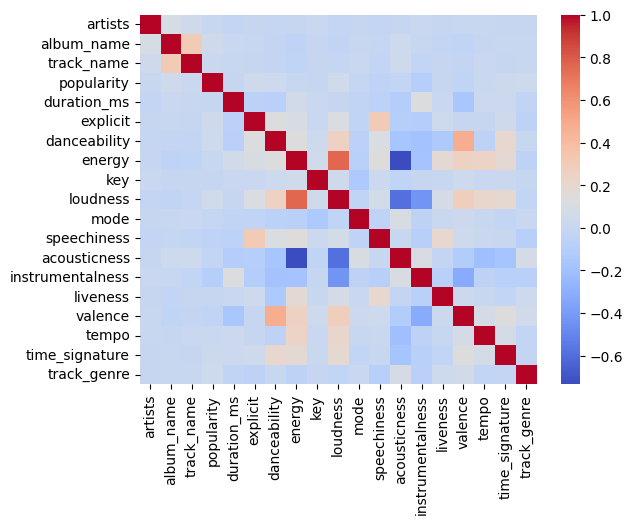

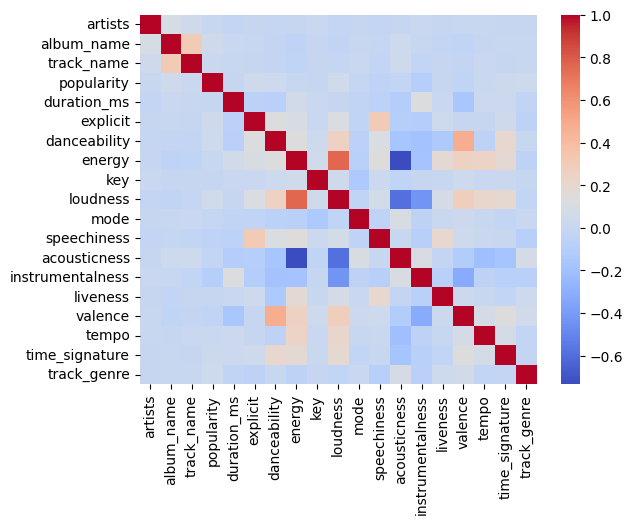

In [102]:
# correlate numeric values using min-max scaling
scaled = (df - df.min()) / (df.max() - df.min())

sns.heatmap(scaled.corr(), cmap='coolwarm')
plt.show()

sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

In both scaled and non-scaled correlations, popularity is not strongly associated with any particular feature.  Though, based off color coding it seems that instrumentalness and speechiness have the strongest correlation, followed by duration_ms, energy, key, mode, acousticness, liveness, and valence.  The remaining features had the weakest correlation to popularity.

### Visualize Strongest Features

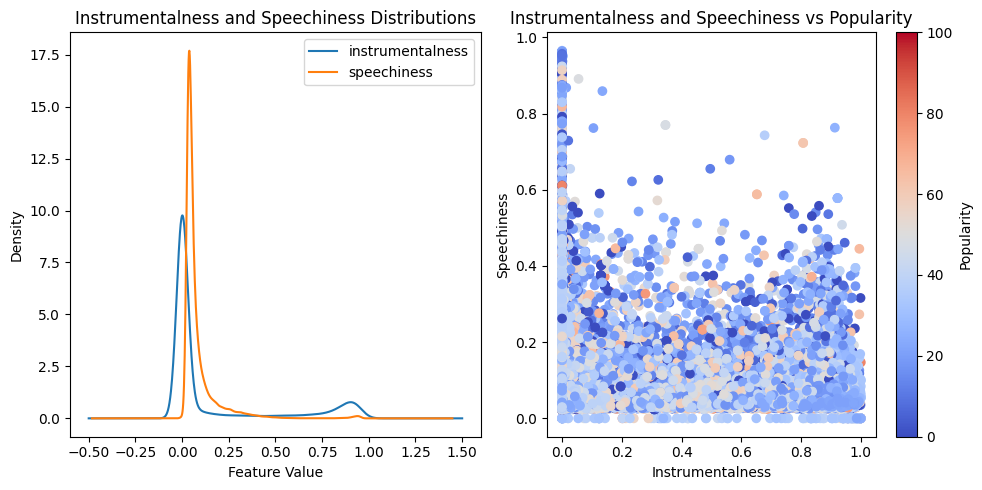

In [90]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the distributions of instrumentalness and speechiness
df[['instrumentalness', 'speechiness']].plot(kind='kde', ax=ax1)
ax1.set_title('Instrumentalness and Speechiness Distributions')
ax1.set_xlabel('Feature Value')
ax1.set_ylabel('Density')

# Plot the relationship between instrumentalness, speechiness, and popularity
scatter = ax2.scatter(df['instrumentalness'], df['speechiness'], c=df['popularity'], cmap='coolwarm')
ax2.set_title('Instrumentalness and Speechiness vs Popularity')
ax2.set_xlabel('Instrumentalness')
ax2.set_ylabel('Speechiness')
cbar = plt.colorbar(scatter)
cbar.set_label('Popularity')

plt.tight_layout()
plt.show()

### Principal Component Analysis

In [130]:
def pca(data, features):
    pca = PCA(n_components=2)
    pca.fit(data[features])
    transformed = pca.transform(data[features])

    # Plot the transformed data
    plt.scatter(transformed[:, 0], transformed[:, 1], c=data['popularity'], cmap='plasma')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA')
    plt.show()

    print(pca.explained_variance_ratio_)

    return pd.DataFrame(data=transformed, columns=['PC1', 'PC2'])

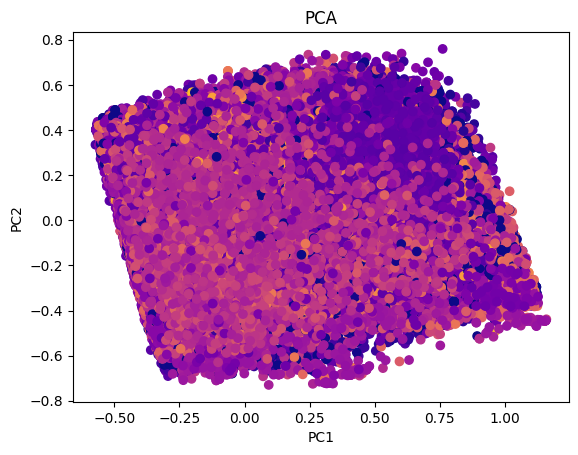

[0.55536798 0.2514782 ]


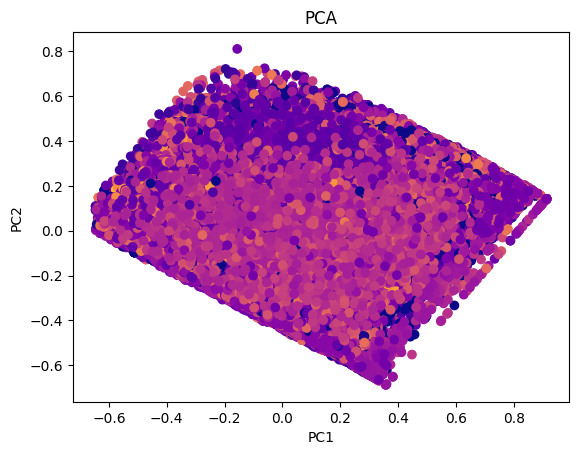

[0.55529201 0.31677051]


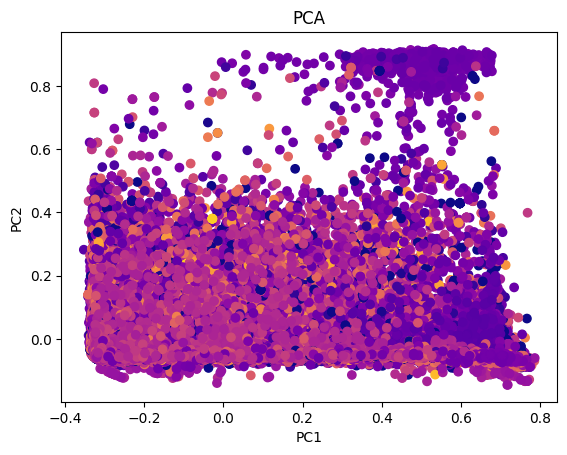

[0.86760168 0.09127323]


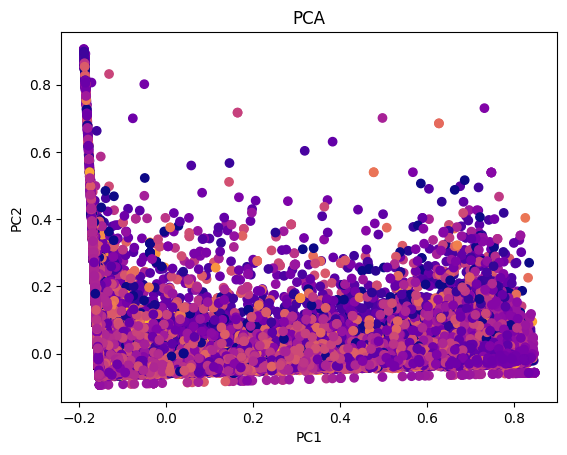

[0.88968743 0.11031257]


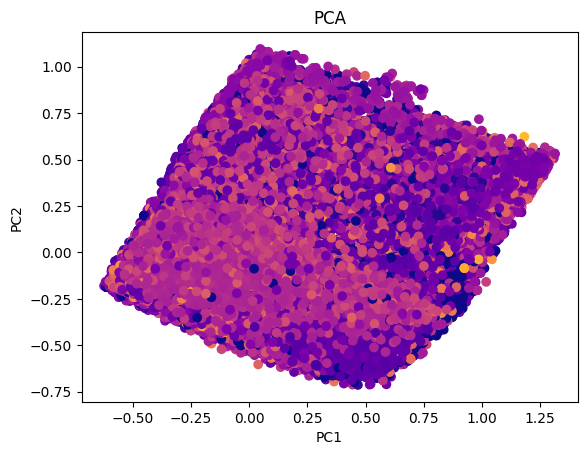

[0.40131027 0.24968644]


In [134]:
pca(scaled, ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'valence'])
pca(scaled, ['valence', 'energy', 'danceability'])
pca(scaled, ['speechiness', 'loudness', 'acousticness'])
pca(scaled, ['instrumentalness', 'speechiness'])
pca_data = pca(scaled, ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'])

### Clustering

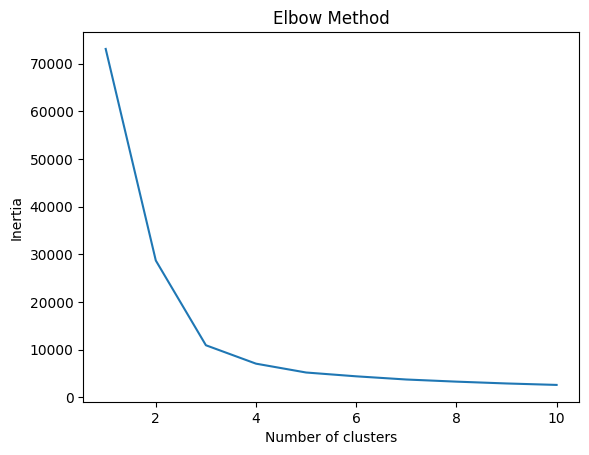

In [142]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    inertia = []

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        inertia.append(kmeans.inertia_)

    sns.lineplot(x=range(1, 11), y=inertia)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

Based on the elbow method, it looks like 3 clusters is optimal.  Now, cluster the data using K-Means clustering and visualize.

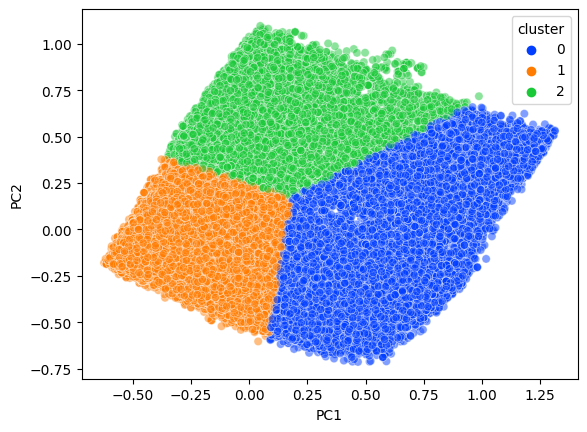

In [143]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(pca_data)
    pca_data['cluster'] = kmeans.labels_

    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='cluster', palette='bright', alpha=0.5)
    plt.show()

### Model Training